In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, average_precision_score, f1_score, precision_score, fbeta_score
from sklearn.linear_model import LogisticRegression

from imblearn.combine import SMOTEENN
from scipy.stats import zscore

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) 

import shap
shap.initjs()

RANDOM_STATE=20

In [2]:
from utils import *

In [3]:
df_train = pd.read_csv("train.csv")
df_valid = pd.read_csv("valid.csv")
df_test = pd.read_csv("test.csv")

### Optuna Hyperparameter Tuning

#### Finding hyperparameter with the best recall

In [4]:
def log_objective_recall(trial):
    X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)
    
    params = {
        'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_float("C", 1e-2, 1),
        'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
        'solver' : trial.suggest_categorical('solver' , ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    }
    
    model = LogisticRegression(**params, max_iter=10000, random_state=RANDOM_STATE)
    model.fit(X_train , y_train)
    
    predictions = model.predict(X_valid)
    
    return recall_score(y_valid, predictions)

In [5]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial : log_objective_recall(trial), n_trials=50)
print("Number of finished trials: ", len(study.trials))

Number of finished trials:  50


In [6]:
trial = study.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 36
	params: {'tol': 0.0006689868769234771, 'C': 0.07579838402386926, 'fit_intercept': False, 'solver': 'saga'}
	values: [0.8805970149253731]


In [7]:
best_recall_params = trial.params
X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)

clf = LogisticRegression(**best_recall_params, max_iter=10000, random_state=RANDOM_STATE)

predictions = obtain_predictions(clf, X_train, y_train, X_valid, y_valid)
get_scores(y_valid, predictions)

Precision: 8.212
Accuracy: 41.060
Recall: 88.060
F1: 0.150
Fbeta: 0.299
ROC AUC: 0.631
PR AUC: 0.079


#### Finding hyperparameter with the best f2 score

In [8]:
def log_objective_fbeta(trial):
    X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)
    
    params = {
        'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
        'C' : trial.suggest_float("C", 1e-2, 1),
        'fit_intercept' : trial.suggest_categorical('fit_intercept' , [True, False]),
        'solver' : trial.suggest_categorical('solver' , ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    }
    
    model = LogisticRegression(**params, max_iter=10000, random_state=RANDOM_STATE)
    model.fit(X_train , y_train)
    
    predictions = model.predict(X_valid)
    
    return fbeta_score(y_valid, predictions, beta=2)

In [9]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial : log_objective_fbeta(trial), n_trials=50)
print("Number of finished trials: ", len(study.trials))

Number of finished trials:  50


In [10]:
trial = study.best_trial
print(f"Trial of Choice: ")
print(f"\tnumber: {trial.number}")
print(f"\tparams: {trial.params}")
print(f"\tvalues: {trial.values}")

Trial of Choice: 
	number: 30
	params: {'tol': 0.0003537740632593671, 'C': 0.0672402949247577, 'fit_intercept': False, 'solver': 'liblinear'}
	values: [0.3014184397163121]


In [11]:
best_fbeta_params = trial.params
X_train, y_train, X_valid, y_valid, X_test, y_test = with_resampling(df_train, df_valid, df_test)

clf = LogisticRegression(**best_fbeta_params, max_iter=10000, random_state=RANDOM_STATE)

predictions = obtain_predictions(clf, X_train, y_train, X_valid, y_valid)
get_scores(y_valid, predictions)

Precision: 8.275
Accuracy: 41.104
Recall: 88.806
F1: 0.151
Fbeta: 0.301
ROC AUC: 0.635
PR AUC: 0.080


### SHAP

Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

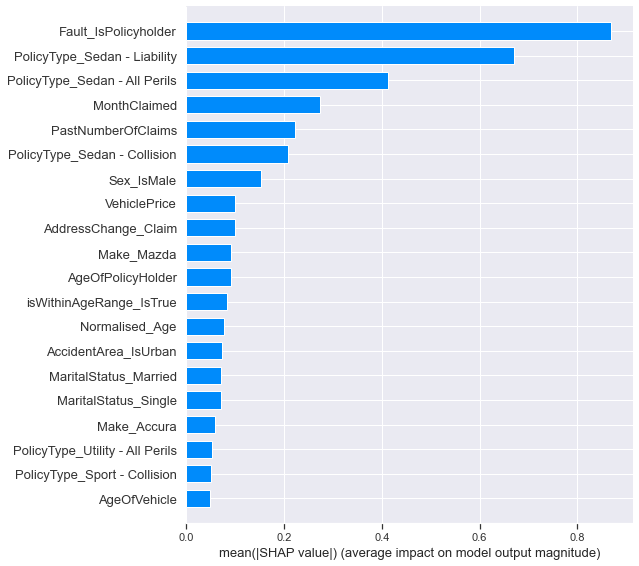

In [12]:
explainer = shap.LinearExplainer(
    clf, 
    masker=shap.maskers.Impute(data=X_train),
    method='linear',
    feature_names=df_train.drop('FraudFound_P', axis=1).columns,
    random_state=RANDOM_STATE
)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

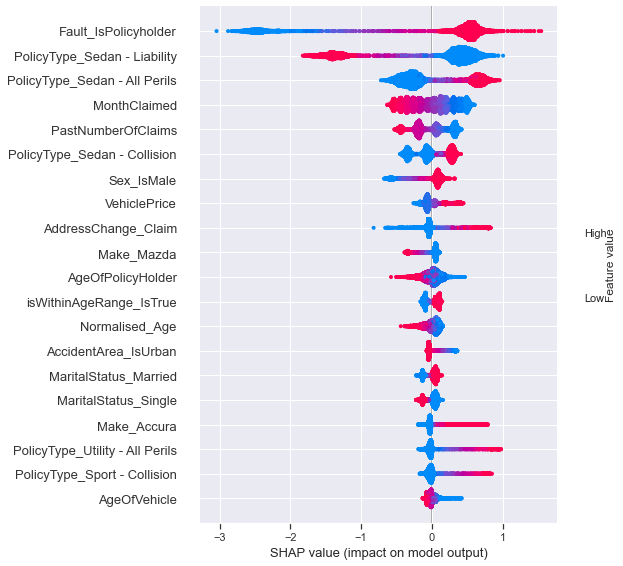

In [13]:
features  = df_train.drop('FraudFound_P', axis=1).columns.tolist()
shap.summary_plot(shap_values, X_train, features)